---
title: "Chapter 3, Part 1: Introduction to Regression"
subtitle: "Machine Learning"
date: "February 2026"
date-format: "MMMM YYYY"
author: 
  - F.San Segundo & N.Rodríguez
bibliography: ../exclude/mlmiin.bib
execute:
  echo: true
code-overflow: wrap
format: 
  html: 
    toc: true
    code-tools: true
    code-fold: show
    code-summary: "Hide the code"
    embed-resources: true
---

::: {.callout-warning icon=false}

##### Setting the working directory

We begin by using cd to make sure we are in the right folder.

:::

In [118]:
%cd 3_1_LinearRegression/

[Errno 2] No such file or directory: '3_1_LinearRegression/'
/wd/3_1_LinearRegression


---

# Session Setup

::: {.callout-note  icon=false}

### Libraries

Let us begin by loading the libraries we will use.

:::



In [119]:
### Load necessary modules -------------------------------
# interactive plotting
# %matplotlib inline
%config InlineBackend.figure_format = 'png' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set()
import statsmodels.api as sm


# Data management libraries
import numpy as np 
import pandas as pd
import scipy.stats as stats

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# others
import warnings

# Connecting statsmodels with sklearn via sklearn2pmml and patsy 
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor 

from sklearn2pmml.statsmodels import StatsModelsRegressor

# patsy for lineal model formula language
import patsy as ps

from patsy_utils.patsy_formulaic_transformer import FormulaTransformer

---

#  Regression

::: {.callout-note icon=false}

## Introduction

In this session we begin our study of the second large family of supervised learning projects; namely, regression problems. The difference between regression and the classification problems that we have been discussing is the **nature of the output variable $Y$**. While in classification $Y$ was a factor (categorical), in regression **$Y$ is a numerical variable**.

This change in $Y$ will impact some parts of our work. For example, the way we define the **prediction error** that we use to measure the model's performance has to change. But we will see that many concepts are common to both classification and regression. For example we continue to assume that the true relation between inputs $X$ and output $Y$ is
$$Y = f(X) + \epsilon,\qquad\text{ with }E(\epsilon) = 0$$
where $\epsilon$ is a (0-mean) random variable, called **random error**. And the bias-variance trade-off that we met in Session 2_3 still holds without changes (because it was in fact expressed in a regression context):
$$
\underbrace{E\left(y_0 - \hat f(x_0)\right)^2}_{\text{Expected generalization error}} = 
\underbrace{\operatorname{Var}\left(\hat f(x_0)\right)}_{\text{Variance}} + 
\underbrace{\operatorname{Bias}\left(\hat f(x_0)\right)^2}_{\text{Bias (squared)}} + 
\underbrace{\operatorname{Var}\left(\epsilon\right)}_{\text{Irreducible error}}
$$  

Just as we did with classification, we are going to meet different type of regression models. And as we do we will see that the idea of the flexibility of the model and the role it plays in this bias-variance tradeoff is essentially the same.

:::

---

# Simple Linear Regression

::: {.callout-note icon=false}

## Introduction to Linear Models

Our first family of regression models was historically also the first one. Linear models have been used for many years now and they continue to be one of the cornerstones of modeling. We said that Logistic Regression was the reference model in classification, and linear models play the same role in regression: they are easy to train, their theoretical foundation is very well understood and they are highly interpretable. The major drawback of the basic version of linear models is their lack of flexibility. They are essentially rigid models and in many cases they suffer from high bias. 

We will begin our discussion as usual in a low dimensional setting and using synthetic datasets to help us visualize the core ideas of these methods. 

:::

---

::: {.callout-note icon=false}

### Example: (Oxygen Consumption and Temperature in Common Blue Tits)

Authors Haftorn and Reinertsen wrote a 1985 paper ([@Haftorn85], see the [References Section](#References) below) about the relationship between oxygen consumption and air temperature in the incubating females of the [*Eurasian blue tit (Cyanistes caeruleus)*](https://en.wikipedia.org/wiki/Eurasian_blue_tit) a common small passerine bird like the one in the picture below:  

![](./fig/3_1_Herrerillo.png){width=40% fig-align="center" fig-alt="Herrerillo Común"}

Think about this questions:  
   + What do you expect to happen with the oxygen consumption as the air temperature drops?
   + Are those two variables equally easy to measure?

The two variables involved in this study are both of them continuous, so the result of a set of measurements will be a collection of pairs 
$$
\quad\\
(x_1, y_1),\, (x_2, y_2), \ldots,\, (x_n, y_n)
\quad\\
$$
that we can represent as points in a scatter plot like the ones we have seen before. 

:::

---

::: {.callout-note icon=false}

### Simple linear Model is about Describing a Trend

This example can be described in symbols as
$$
O_2\sim T
$$
We are using air temperature $T$ as input variable and $O_2$ as output because of what your intuition told you after thinking about the questions above. That same intuition is surely leading you to the conjecture that when you place air temperature in the $X$ axis and oxygen consumption $(O_2)$ on the $Y$ axis then the points of the scatter plot will describe a trend such as this one:  

![](./fig/3_1_IntuicionProblemaHerrerillos.png){width=40% fig-align="center" fig-alt="Intuition for the O2 consumption vs temperature"}

The data collected by the authors of that paper resulted in this scatter plot (there are two samples represented by different symbols, one for the incubation period and the other outside that period):

![](./fig/3_1_Figura05HaftornReinertsenHerrerillos.png){width=40% fig-align="center" fig-alt="Haftorn and Reinertsen 1985 Scatterplot"}

This confirms our intuition and is a typical example of the kind of pattern we are looking for. You can see that the authors have drawn two straight lines (one for each sample). This straight lines are a *mathematical abstract model* of the trend that appears in the data. Many other variables, aside from air temperature, play a role in the $O_2$ consumption for these birds. So none expects the relation between these two variables to be perfectly described by such an abstraction as a straight line is! Every real world relation is noisy, even the most controlled lab experiments include some level of noise in their measurements. But the straight line in that picture is the model or signal that *best describes* the trend that we observe in the data.And of course we expect this model to be biased. But then, in what sense do we say that this line is *the best among all posable lines*? Note that there may be functions other than straight lines that do a better job. But for now the competition is restricted to straight lines.

:::

---

::: {.callout-note icon=false}

### Signal and Noise and Linear Relations. Three different datasets example.

The three scatter plots below show examples of noisy relations $Y\sim X$ between two continuous variables.  The first one on the left is a relation that can be well described using a straight line as a model, like in the birds example. The central panel also shows a clear and well defined relation between the variables (*strong signal, weak noise*). But it would be foolish to try to describe it with a straight line. The last one, finally, does not seem to show any discernible pattern (*weak or no signal, very strong noise*), and so it seems that this variables are unrelated.

The code below makes these plots and creates the corresponding datasets in your folder (overwrites them if they are already there).

:::

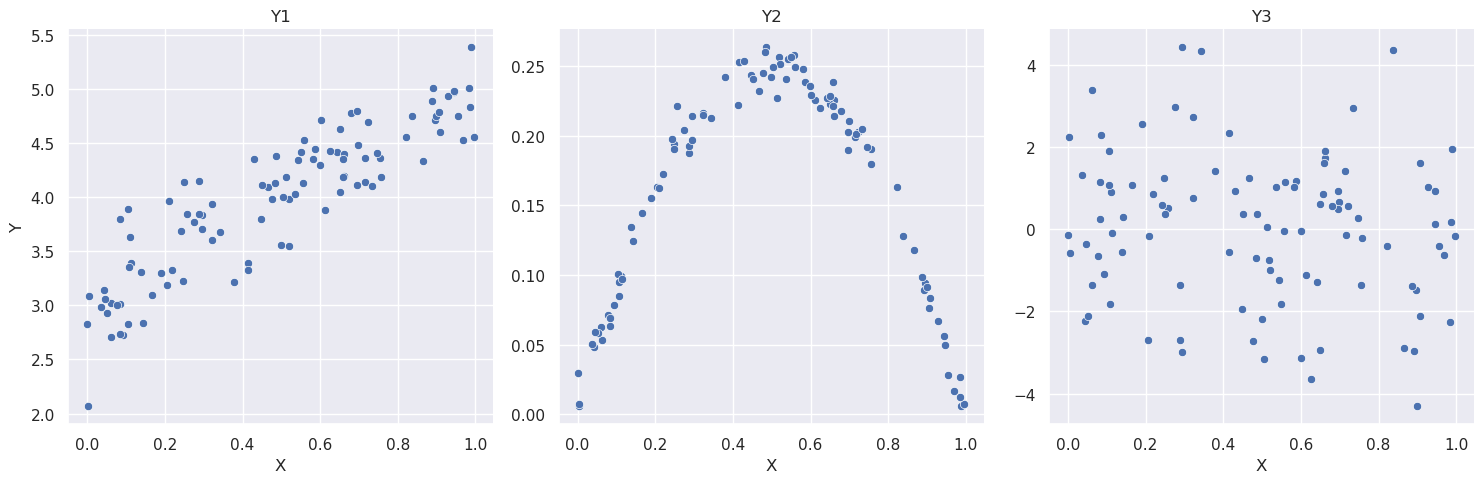

In [120]:
%run -i "./3_1_models_01.py"

---

::: {.callout-note icon=false}

### The Regression Line

So we will try to focus in a situation like the first panel from the left, where the relation $Y\sim X$ seems to be well suited to be described using a straight line. We want to choose the **best possible** straight line, and we will call it the **regression line** for $Y\sim X$.  

The data for that example (first panel) are contained in the [07_simple_linear_regression_01.csv](./data/07_simple_linear_regression_01.csv) file. In this example the best line is the one that appears below. We will soon discuss the code details. But to get there we will follow these steps:

  1. First we will clarify what we mean by *the best straight line.*
  2. Then we will see how to obtain that line, both theoretically and using Python.
  3. We will see that sometimes even the best possible line is really bad.

  :::

::: {.callout-note icon=false}

### Linear Regression Basic Models in Scikit-learn

Scikit provides the class [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to fit linear regression models. This class can be used in pipelines just the ones we have been using until now. 

:::

In [121]:
df = pd.read_csv("./3_1_simple_linear_regression_01.csv")

inputs =["X0"]
output = "Y"

sk_lm = LinearRegression( ) 
sk_lm.fit(df[inputs], df[output])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [122]:
b0 = sk_lm.coef_[0]
b1 = sk_lm.coef_[0]

b0, b1

(np.float64(2.002986467673893), np.float64(2.002986467673893))

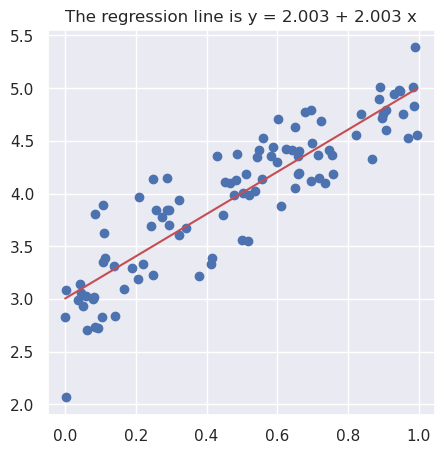

In [123]:
sns.set_theme(rc={'figure.figsize':(5, 5)})


X_new = np.linspace(df[inputs].min(), df[inputs].max(), 10).ravel()
Y_new = sk_lm.predict(pd.DataFrame({"X0":  X_new}))

plt.plot(df[inputs], df[output], 'bo')
plt.plot(X_new, Y_new, 'r-')
plt.title("The regression line is y = {:.4} + {:.4} x".format(b0, b1))
plt.show();plt.close()

::: {.callout-note icon=false}

### The Situation with Linear Models in Python

The problem with the LinearRegression class (and with scikit in general) is that it is focused on *modeling for prediction*. Which is fine if that is you care about. But for some models, and particularly in the case of linear models, we want more information. For example, about the significance of coefficients like we did for logistic regression. 

As we saw then, the Python library that provides that type of information about linear models is called [Statsmodels](https://www.statsmodels.org/). Our work with Python would be much easier if Statsmodels and Scikit shared some common principles. But unfortunately that is not the case. There are, however, third party attempts to combine the information provided by both libraries. We will use some of these connections, but in order to do that we need to upgrade our Python environment.

:::

---

::: {.callout-warning icon=false}

### Conda environment upgrade.

The code for this session will not work until you upgrade the `MLMIC25` environment. To do that follow the next instructions:

1. Make a clone (backup) of your environment by opening a terminal and running:  
`conda create --name MLMIC25bkup --clone MLMIC25`  
Answer yes when you are asked if you want to proceed.  
</br>  
2. **Remember to activate your MLMIC25 environment!**  
</br>  
3. Run the following commands one by one (so that if you run into trouble we will know the culprit).   
`pip install patsy`  
`pip install sklearn2pmml`  
</br>    
3. After you have used the environment for several days, if things remain stable and you need to free the space in your disk, you can get rid of the backup by running  
`conda remove --name MLMIC25bkup --all`

:::

::: {.callout-note icon=false}

### A First Linear Model 

The following code (uncomment and run the cell to load it) uses our upgraded environment to fit a regression model (from statsmodels) using the pipeline framework (from scikit) that we are used to. 

**Note:** you may get a warning that you can ignore by now.

:::

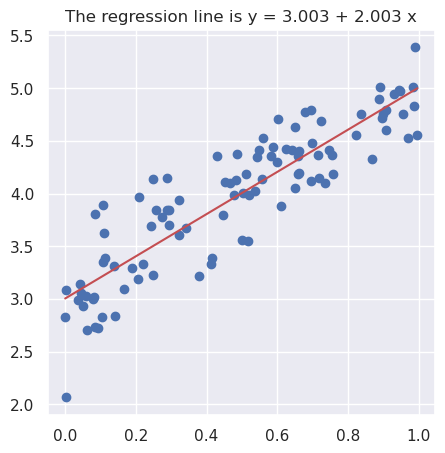

In [124]:
%run -i "3_1_models_02.py"

::: {.callout-tip  icon=false}

### Exercise 001

+ Browse the code and do not worry if you do not get it just now. It will become clear as we move forward. Ask questions, though! 

+ Run the code for the datasets `3_1_simple_linear_regression_02.csv` and `3_1_simple_linear_regression_03.csv`. These correspond to the center and right panel of the examples above. 

+ When you run this exercise you will see that the regression line does not seem to be a good model of the data in the last both cases, but for different reasons. Can you explain the difference?

:::

---

::: {.callout-note icon=false}

### The Equation of the Regression Line. Predicted Values and Residuals.

To carry on with our plan we introduce some notation. The equation of the regression line will be written as:
$$
y = b_0 + b_1\, x
$$
where $b_1$ is the **slope** of the line. The sign of $b_1$ reflects if the line is going up or down as we move to the right. Its absolute value equals how many units $y$ changes when $x$ changes by one unit. The value of $y$ when $x = 0$ is $b_0$, the **intercept**. 

Let us assume that $b_0$ and $b_1$ are known values. Then if the sample points are:
$$
(x_1, y_1),\, (x_2, y_2), \ldots,\, (x_n, y_n)
$$
when we plug each $x_i$ in the equation of the regression line we get  *another value* of $y$ (usually different from $y_i$), that we call the **predicted value** and denote by
$$
\hat y_i = b_0 + b_1\, x_i,\quad\text{for each }\quad i =1,\ldots,n
$$

The **residuals** are the differences:
$$e_1 = y_1 - \hat y_1,\,\quad  e_2 = y_2 - \hat y_2,\quad  \ldots\quad ,\,e_n = y_n - \hat y_n $$    

All these terms are illustrated in the figure below:
  + The red dots correspond to the original sample points, with (vertical coordinates) $y_1, \ldots, y_n$.
  + The green dots are the predicted values, with $\hat y_1, \ldots, \hat  y_n$.
  + The residuals $e_1, \ldots, e_n$ measure the lengths of the vertical segments connecting each red point to the corresponding green one.
  
![](./fig/3_1_Residuals.png){width=60% fig-align="center" fig-alt="Residuals and Predicted Values in SImple Linear Regression"}

:::

---

::: {.callout-note icon=false}

### Mean Squared Error (MSE)

Since the residuals measure the vertical distance from the predicted to the actual value, a good regression line should give us a **small residuals average**. Note that we need to think about some kind of residual average, because otherwise the line could be good in some regions and really bad in some others. 

The first idea that comes to mind is to take the mean of the residuals. But then the positive and negative ones could cancel and that would be a misleading measure of the quality of that line. We could take absolute values, but this way leads to complicated mathematics. Therefore we give a different definition.

The **squared error** or also **RSS (residuals squared sum)** for the line given by $b_0$ and $b_1$ is:
$$
RSS =
\sum_{i=1}^n e_i^2 =
\sum_{i=1}^n(y_i-\hat y_i)^2 =
\sum_{i=1}^n(y_i-b_0-b_1\cdot x_i)^2.
$$
and the **(sample) square mean error** is 
$$\operatorname{SME} = \dfrac{RSS}{n-1}$$
You can probably guess the reason why we divide by $n - 1$ instead of $n$, we will return to that issue below.

The idea of the square error (and the *least squares method*) is illustrated [in this figure](https://www.geogebra.org/m/pryzjnya):
![](./fig/3_1_QuadraticErrorMeaning.png){width=80% fig-align="center" fig-alt="https://www.geogebra.org/m/pryzjnya"}

:::

---

::: {.callout-note icon=false}

### Performance Measures for Regression Root Mean Squared Error (RMSE)

We have met the concept of residuals measure in the context of simple linear regression. But whenever we have a model estimator $\hat f$ that estimates the true relationship 
$$Y = f(\bar X) + \epsilon$$
the general definition of residual as 
$$e_i = y_i - \hat y_i = f(\bar X_i) - \hat f(\bar X_i)$$    
can be applied. The residuals themselves are estimates of the error term in the true relation.  

Therefor the mean squared error is defined for any regression model. The main problem using it is that its units are not those of the original problem. And as usual we take the square root to define the **RMSE (Root Mean Squared Error)**
$$
\operatorname{RSME} = \sqrt{\dfrac{\displaystyle\sum_{i=1}^n e_i^2}{n}}
$$
In classification problems we used accracy as the general performance measure. And in fact it is used as default in scikit classifiers. This RMSE measure  plays a similar role for regression models. There are many alternatives and we will find some of them in the examples of future sessions.  For example, an alternative using absolute values instead of squares is the **mean absolute error (MAE)** defined as:
$$
\operatorname{MAE} = \dfrac{\displaystyle\sum_{i=1}^n |e_i|}{n}
$$



::: {.callout-tip  icon=false}

### Exercise 002

The residuals of the model we fitted in the previous exercise are stored in the `model.results_.resid`. Use it to compute directly the SME and RSME for the dataset in `3_1_simple_linear_regression_01.csv`.

What happens if you sum the residuals without squaring them first?

:::

In [125]:
# %run -i "../exclude/code/3_1_Exercise_002.py"

---

::: {.callout-note icon=false}

### The Coefficients of the Regression Line

 The best line (the linear regression line) is the one with those values of $b_0, b_1$ that result in the least squared error. Using Calculus to solve that optimization problem leads to this:

**Equation of the Linear Regression Line.**
$$
\hspace{1cm}(y-\bar y)=\dfrac{\text{Cov}(x,y)}{s^2(x)}\cdot (x-\bar x)
$$
where the **sample covariance**  is:
$$\text{Cov}(x,y)=\dfrac{\displaystyle\sum_{i=1}^{n}(x_i-\bar x)(y_i-\bar y)}{n-1}
$$
Therefore the coefficients of the regression line (in the one dimensional setting) are:
$$
\begin{cases}
b_1= & \dfrac{\text{Cov}(x,y)}{s^2(x)}\\[5mm]
b_0= & \bar y - \dfrac{\text{Cov}(x,y)}{s^2(x)}\cdot\bar x
\end{cases}
$$

**Note** in particular these results have two important consequences:
  + The regression line always goes through the *sample center*, the point $(\bar X, \bar Y)$.
  + The sum of the residuals for the regression line is always 0.

:::

::: {.callout-tip  icon=false}

### Exercise 003

Locate in `3_1_models_02.py` how to get to the model coefficients.

:::

---

::: {.callout-note icon=false}

###  Analysis of Variance and ANOVA Identity for Simple Linear Regression

Recall that the residual squared error, also called **residual sum of squares** or **SSresidual**, was defined as:
$$SSresidual =  \sum_{i=1}^n e_i^2 =  \sum_{i=1}^n(y_i-\hat y_i)^2 =\sum_{i=1}^n(y_i-b_0-b_1\cdot x_i)^2.$$
This squared error is defined from the residuals of the linear regression and it is therefore connected to the *noise* part of that *noise / signal* duality we have been talking about. That is why we are .

You may have noticed that the second term above resembles the numerator of the variance of $y$. Playing with that idea and doing some algebra we arrive at this very important expression:  

**Anova Identity for Simple Linear Regression**
$$
\underbrace{\displaystyle\sum_{i=1}^{n}(y_i-\bar y)^2 }_{SStotal}=
\underbrace{\sum_{i=1}^n e_i^2}_{SSresidual} + 
\underbrace{\sum_{i=1}^n(\hat y_i-\bar y)^2}_{SSmodel}
$$

The Anova identity is a purely algebraic equation, it does not depend on assumptions about the distribution of the variables in the model.  This equation provides a decomposition of the total spread $SStotal$ of the response $y$ values.  We have already mentioned that $SSresidual$ is related to the *noise* in the data. But the $SSmodel$ term is obtained from the predicted values of the model. That is, even if there was no noise at all and the original data were perfectly placed on this regression line, their $y$ coordinates would be vertically spread, *simply due to the slope of the regression line itself*. That means that this component of the total $y$ spread is the part that is fully **explained by the model**. The following picture shows two extreme situations in the Anova identity. In each case one of the terms in the right hand side sum equals zero.

![](./fig/3_1_Anova_Signal_Noise.png){width=80% fig-align="center" fig-alt="Signal and Noise in the Anova identity for Linear Regression"}




:::

---

::: {.callout-note icon=false}

### Goodness of Fit and Pearson's Correlation Coefficient

Dividing the Anova identity by $SStotal$ we arrive at:
$$
1 = \dfrac{SS_{residual}}{SS_{total}} + \dfrac{SS_{model}}{SS_{total}} = 
\dfrac{SS_{residual}}{\displaystyle\sum_{i=1}^{n}(y_i-\bar y)^2}
+
\dfrac{\displaystyle\sum_{i=1}^n(\hat y_i-\bar y)^2}{\displaystyle\sum_{i=1}^{n}(y_i-\bar y)^2}
$$
The division guarantees that the terms on the right hand side:  
  $(a)$ are *dimensionless* (or *unit-less*) and do not depend on the scale of the problem.  
  $(b)$ are *positive and add up to 1*.  
  $(c)$ the first term refers to the  *noise* component of the data, while the second refers to the  *model*  (the regression line). 
  
In particular, this seems to indicate that quality of the regression line increases the bigger this second term is  (and therefore, the smaller the first one is). 

If we plug $(\hat y_i - \bar y) =  \dfrac{\text{Cov}(x,y)}{s^2(x)}(x - x_i)$ into $SS_{model}$ we arrive at
$$
1 = \dfrac{SS_{residual}}{\displaystyle\sum_{i=1}^{n}(y_i-\bar y)^2} + \left(
\dfrac{\text{Cov}(x,y)}{s(x)\cdot s(y)} \right)^2
$$
And the term in parenthesis is therefore a measure of the **goodness of fit** to the data provided by this regression line model. Let us give it a name:  

**Pearson's Correlation Coefficient $R$**
$$
R = \text{Cor}(x,y) = \overbrace{\text{Cor}(y, x)}^{\text{is symmetrical }} = \dfrac{\text{Cov}(x,y)}{{s(x)\cdot s(y)}}
$$

Using the correlation coefficient we can rewrite some previous results:
  + The **Anova identity** is
  $$1 = \dfrac{SS_{residual}}{SS_{total}} + R^2$$
  + The **regression line equation** is
  $$(y - \bar y) = \text{Cor}(x,y)\dfrac{s(y)}{{s(x)}} (x - \bar x)$$


:::

::: {.callout-note icon=false}

### Properties of the Correlation Coefficient

Symmetry: $\text{Cor(X, Y)} = \text{Cor(Y, X)}$. The correlation coefficient is a dimensionless number between $-1$ and $1$. The sign of $R$ is the same the sign of the slope $b_1$ for the regression line. Thus, if $R > 0$ the line increases and conversely.

$R$ only equals $1$ or $-1$ when **every point** in the sample is perfectly aligned on the regression line.

$R^2$ is called the **coefficient of determination** and it represents the proportion (or percent) of the total $y$ variation that can be explained by the model.

Let $\tilde x_i = \dfrac{x_i - \bar x}{s_x}$ be the centered and scaled values of the $x_i$ and similarly let $\tilde y_i$ be the centered and scaled values of the $y_i$. The regression line can be written 
$$\tilde y_i = R\cdot \tilde x_i$$ 
This can be seen as a regression line for $\tilde y$ and $\tilde x$. Its slope has an absolute value smaller than one, thus explaining the phenomenon known as *regression to the mean*, that gives name to the whole method.

:::



::: {.callout-note icon=false}

### Interpretation of the Correlation Coefficient

+ Whenever $R$ is close to 0, the fit of the line to the data is certainly bad.  
+ Whenever the fit of the line to the data is good bad, then $|R|$ is close to 1.
+ **Be careful, it does not work the other way round!** If the value $|R|$ is close to 1 that  **does not guarantee by itself  the goodness of fit. Always check the fit, at least graphically!**
      
:::

Take a look at this figure and note that *the lowest $R$ value corresponds precisely to the one case where the line is a indeed a good model for the data*.  

![](./fig/3_1_PearsonR_Interpretation_01.png){width75% fig-align="center" fig-alt="Interpretation of the Correlation COefficient"}

Another important observation about correlation is that it should not be interpreted as causality. Too often the news headlines run sentences like "using (or eating) A linked to cases of B". And this often comes after a study found a correlation between those two things, without the study proving (or even trying to prove) any sort of causality. 

![](./fig/3_1_XKCD552correlationCausation.png){width=75% fig-align="center" fig-alt="XKCD correlation vs causation"}

::: {.callout-tip  icon=false}

### Exercise 004

Use the `model.results_` object to find the value of $R^2$ in this case.

:::

In [126]:
# %run -i "../exclude/code/3_1_Exercise_004.py"

---

# Distributional Assumptions of the Linear Regression Model

::: {.callout-note icon=false}

### Model Bias and Variance in Simple Linear Regression. 

The linear models (regression lines) that we fitted in previous examples were obtained from a **single concrete sample**. And the discussion about *goodness of fit* above is concerned with **how the regression line fitted the particular sample** from where it came. But in order to get a clear understanding and a wider perspective of the notion of model variance we can use this simple type of models, and think in terms of populations and not just individual samples. 


Our starting point is the idea that the pattern we have spotted in a sample hints at a pattern when we move up to the population. That *population level pattern* is a *Linear Model*, which again is a mathematical abstraction defined as follows:

$$
\hspace{1cm}Y = \underbrace{\beta_0 + \beta_1 \bar X}_{\text{model}} + 
    \underbrace{\epsilon}_{\text{noise}}
$$
where $\beta_0, \beta_1$ are the model coefficients. Here we assume that the true form of the relation is 
$$Y = f(\bar X) + \epsilon, \textbf{ with } f(\bar X) = \beta_0 + \beta_1 \bar X$$
It may perfectly well be the case that the true nature of $f$ is not linear (think about the center panel in the three-datasets example above). This is related to the **model bias** and the only way to fight it here would be by considering more flexible models (e.g. a linear model with quartic terms). We will see examples in the next sessions. But the idea of model variance is related to the dependance of the fit with respect to the sample, and we are going to explore that below.

---

::: {.callout-note icon=false}

### Statistical Assumptions for the Linear Regression Model. 

As we have seen the linear model is given by 
$$
Y = {\beta_0 + \beta_1 X} + {\epsilon}
$$
where $\beta_0, \beta_1$ are the **model coefficients**. 

The minimal requirement for the **error variables** is that their conditional (on $\bar X$) mean is equal to 0. That is 
$$E(\epsilon|\bar X) = 0$$
Taking this conditional average above leads to 
$$E(Y|\bar X) = E({\beta_0 + \beta_1 X} + {\epsilon}|\bar X)$$
and using linearity of expectations
$$E(Y|\bar X) = \beta_0 + \beta_1 X$$
The linear model equation represents the expected value of $Y$ given $\bar X$. 

Usually we would like to go beyond this and perform e.g. statistical tests of significance for the coefficients of the model. In order to do that we add extra requirements:

The  error variables $\epsilon$ are supposed to be conditionally independent (given the value of $X$) and with identical (conditional) normal distributions, all equal to  $N(0, \sigma)$. 

The parameter $\sigma^2$ is the common or **homogeneous variance** of all these error variables.  


Now, of course in any particular data analysis problem this assumptions may not hold. There are many diagnosis tools developed to check if they do, and we encourage you to read more about this (in e.g. [@farawayLMP]). 

:::

---

::: {.callout-note icon=false}

### Fitting Regression Lines for Many Samples of the Same Population

The following code cell does the following: we consider a **population** in which we have two random variables related through an abstract linear model  
$$Y = 4 - 2 X + \epsilon$$
that is, the **theoretical coefficients** are $\beta_0 = 4, \beta_1 = -2$. Then we run a simulation where we have 5 samples (of size $n = 30$ each) of 
We also assume that the common variance for the errors is $\sigma^2 = 0.25$. Let us use numpy to:

1. Get those samples.
2. Fit a regression line for each sample
3. Do a scatterplot of the samples and their corresponding regression lines.
4. Also add a dashed line representing the theoretical population line.

We will add color to the plot to identify the samples.

:::

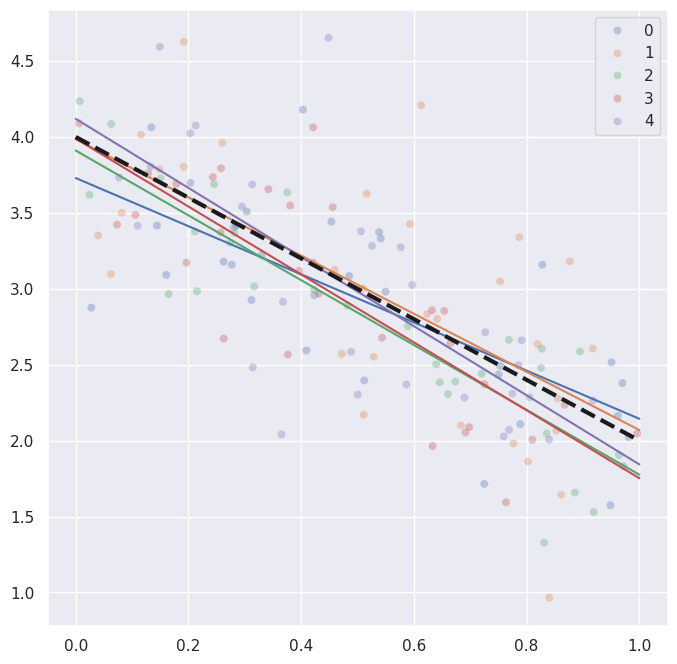

In [127]:
%run -i "3_1_IllustrateModelVariance.py"

::: {.callout-tip  icon=false}

### Exercise 003

+ Load the code for the script. Change the number of lines drawn to be ten times bigger. Run the code and observe the plot. Keep increasing the number of samples. Can you see the shape of the region swept by the different regression lines?

+ Now keep a moderately high number of lines fixed, say $N = 50$. And experiment with the sample size (number of points) $n$. What do you observe?

:::

---

::: {.callout-note icon=false}

### Confidence and Prediction Bands 

Run the following code. As you examine the results of the script you have noticed that the shape of the region swept by the lines looks like the yellow shaded area in the plot resulting from the following script.

The narrow yellow region represents the expected position of the regression line. Note that all the lines are closer in the central part of the $X$ range, and they separate as we move to the boundary of the range because of the uncertainty of the population slope. The result is that **for each fixed value of $X$ we get a confidence interval for the $Y$ mean**. The yellow **confidence band** is made of these intervals. Our distributional assumptions allow us to get closed formulas for these intervals, but we will not see them here (see [@farawayLMP] or Section 3.2 of [@ESLI2009]).

The confidence band represents the expected **average value** of $Y$ given $X$. But sometimes we are interested in the **average range** of $Y$ values given $X$. That is what the blue shaded **prediction band** represents.

We have seen these concepts for linear regression models but you will often see these bands (especially the confidence band) used with many regression models, with a similar interpretation for it.


:::

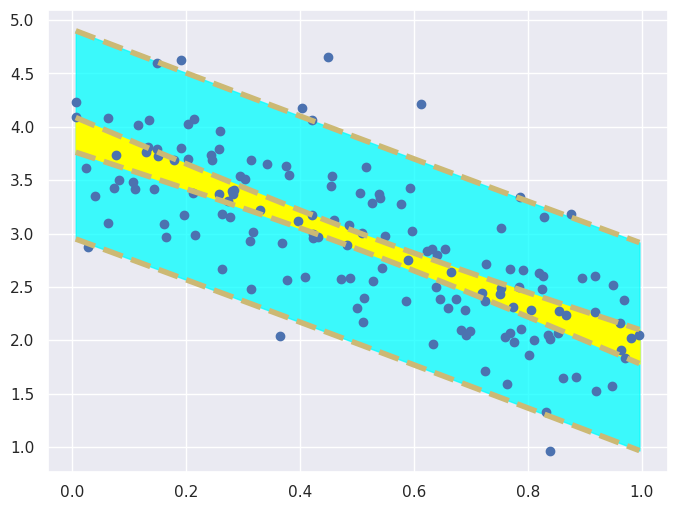

In [128]:
%run -i "3_1_ConfidencePredictionBands.py"

::: {.callout-tip  icon=false}

### Exercise 004

Continue to experiment with the sample size and number of samples and look at the behavior of the confidence and prediction bands as you do so.

:::

---

::: {.callout-note icon=false}

### Hypothesis Tests about the Linear Model Coefficients

Our assumptions about the distribution of the error in the linear model can be used to test several null hypothesis about the coefficients of the model. We can use the results of our previous example to see a table that includes some of them.

By the way, you can not get this kind of summary out of the basic scikit class `LinearRegression`. At least not easily, and that is why we are using patsy to connect to statsmodels.

:::

In [129]:
print(model.results_.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     380.5
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           1.62e-35
Time:                        07:15:21   Log-Likelihood:                -22.754
No. Observations:                 100   AIC:                             49.51
Df Residuals:                      98   BIC:                             54.72
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0034      0.058     51.402      0.0

::: {.callout-note icon=false}

### Interpretation of this Table  

First, note that the value of $R^2$ that we asked you to compute in a previous exercise is displayed at the top right side of the table. The next value of interest for us is the $F$-statistic in that column and the $p$-value right below it (named `Prob (F-statistic)`). This is a global significance test of the model, where the null hypothesis test is: this model does not explain the data better than a *constant (null) model*.  

Next we would check the fitted values and significance tests for the individual coefficients, in the `coef` and  `P>|t|` columns of the central part of the summary. The null hypothesis is that the corresponding coefficient is 0. In this example all p-values are clearly so small that we can reject all the nulls.

:::

---

# Linear Regression in Higher Dimensions: Multiple Linear Regression

::: {.callout-note icon=false}

### Matrix Notation for HIgher Dimensional Problems

Until now we have been illustrating the discussion with **simple linear regression** examples. That is, examples with a single numeric input. But the extension of this ideas to higher dimensional settings using matrix notation is straightforward. We follow the notation in [@ESLI2009, p. 11], except that we use $n$ instead of $N$ for the number of samples. 

A linear model is a model of the form 
$$Y = f(\bar X) +\epsilon \quad \text{ where }\quad f(\bar X) = \beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p$$
where the error functions $\epsilon$ are assumed to be (conditionally on $\bar X$) independent identically distributed normals $N(0, \sigma)$. 

Our starting point, as usual, will be a dataset with $n$ observation of $p$ variables that we can think of as a $n\times p$ matrix. This is called the **design matrix** of our model (the name comes from the realm of *Experimental Design*).
$$
{\mathbf X} =
\left(
\begin{array}{ccccc}
1& x_{11} & x_{12} & \cdots & x_{1p}\\
1& x_{21} & x_{22} & \cdots & x_{2p}\\
\vdots & \vdots &        & \vdots \\
\vdots & \vdots &        & \vdots \\
1 & x_{n1} & x_{n2} & \cdots & x_{np}\\
\end{array}
\right)
$$
Some remarks:
+ We have added an extra first column with all entries equal to 1, because this simplifies the matrix notation below.
+ Each of the remaining columns of the matrix, starting with the second,  corresponds to a variable (as indicated on top of the column) and each row corresponds to an observation. 
+ We assume that all the entries are numerical. In particular that means that some kind of encoding (e.g. one hot) has been applied to the categorical predictors.We will discuss this further when we talk about collinearity below. 

The matrix $\mathbf X$ together with the output vector (considered as usual as a column vector)
$$
\bar Y = 
\left(\begin{array}{c}y_0\\y_1\\\vdots\\y_n\end{array}\right)
$$
constitute the sample data that we use to estimate the model. Due to the random nature of the model we can not expect to obtain true values of the (vector of) $\beta_i$ coefficients: Instead we will obtain **estimates** of these coefficients, and we will use the symbols $\hat\beta_i$ or $b_i$ to refer to these estimates:
$$\hat\beta = \left(\begin{array}{c}\hat\beta_0\\\hat\beta_1\\\vdots\\\hat\beta_p\end{array}\right)$$
In order to obtain them let us first begin defining the **predicted values** (check the matrix dimensions below):
$$
\bar Y =\left(\begin{array}{c}y_0\\y_1\\\vdots\\y_n\end{array}\right) = 
\left(
\begin{array}{ccccc}
1& x_{11} & x_{12} & \cdots & x_{1p}\\
1& x_{21} & x_{22} & \cdots & x_{2p}\\
\vdots & \vdots &        & \vdots \\
\vdots & \vdots &        & \vdots \\
1 & x_{n1} & x_{n2} & \cdots & x_{np}\\
\end{array}
\right)
\left(\begin{array}{c}\hat\beta_0\\\hat\beta_1\\\vdots\\\hat\beta_p\end{array}\right)
 = {\mathbf X}\hat\beta
$$

:::

::: {.callout-note  icon=false}

### Design Matrices in Python. Model Formulae in Patsy.

One of the additions to our environment was `patsy`. According to its [webpage](https://patsy.readthedocs.io/en/latest/overview.html) *patsy is a Python package for describing statistical models (especially linear models, or models that have a linear component) and building design matrices. It is closely inspired by and compatible with the formula mini-language used in R and S.*

The formula language mentioned above provides an easy way to specify model inputs. 

**Examples:** 

In these examples the symbol `~` can be interpreted as *depends on*

+ If we want to describe a linear model with output `Y` and numerical inputs `X0, X1` we can use the formula `Y ~ X0 + X1`.   
  </br>
+ If the model has one squared predictor we simply add one term to the formula: `Y ~ X0 + X1 + I(X0**2)`.  
  </br>
+ Next, if the linear has one numerical input $X_0$ and a categorical input `X1` with levels `A, B, C`, then we use `Y ~ X0 + X1` and patsy is clever enough to figure out the right encoding for `X1`.  
  </br>
+ But if `X1` is categorical  with levels `1, 2, 3` then `Y ~ X0 + X1` would make patsy think that `X1` is numeric. In this case we need to use `Y ~ X0 + C(X1)`
</br>

The code cells  below shows how to obtain the design matrix for a dataset like the first of these examples. Note as well that a column of ones is automatically added to the matrix.

:::

First let us examine the beginning of the dataset. Note the names and types of inputs and output. 

In [130]:
df = pd.read_csv("./3_1_data01.csv")
df.head(3)

,x1,x2,y
0,-0.083784,-0.268621,9.325180
1,-0.982944,-0.118862,7.881259
2,-1.875067,0.065455,5.441091


Now let us write the model formula and use it to obtain a design matrix. We show the first four rows of the design matrix.

In [131]:
model_Formula = "y ~ x1 + x2"
Y, X = ps.dmatrices(model_Formula, df)
X[:4]

array([[ 1.        , -0.08378436, -0.26862147],
       [ 1.        , -0.98294375, -0.11886232],
       [ 1.        , -1.87506732,  0.06545456],
       [ 1.        , -0.18614466,  1.29091527]])

::: {.callout-tip  icon=false}

### Exercise 006

+ Check that `Y` above is precisely the column vector $\bar Y$ in the preceding matrix notation. 
+ Load the `3_1_data07.csv` and inspect the first 10 rows. Then obtain a design matrix for a linear model of this dataset. 


:::

In [132]:
# %run -i "../exclude/code/3_1_Exercise_006py"

---

::: {.callout-note icon=false}

### Residuals and Least Squares. Hat Matrix.

The vector of **residuals** $\bar\epsilon$ is then $\bar e = \bar Y - \hat Y = \bar Y - {\mathbf X}\hat\beta$ (observed minus predicted values). With this matrix notation the residual sum of squares is simply:
$$
SS_{residual} = (\bar Y - {\mathbf X}\hat\beta)^T (\bar Y - {\mathbf X}\hat\beta)
$$
where $T$ indicates the transpose. The solution to the problem of optimizing this sum leads to 
$$
\hat\beta = ({\mathbf X}^T{\mathbf X})^{-1}{\mathbf X}^T \bar Y
$$
provided of course that the $p\times p$ matrix $({\mathbf X}^T{\mathbf X})$ is non-singular. 

If that is the case then 
$$\hat Y =  {\mathbf X}\hat\beta = X (X^TX)^{-1}X^T Y$$
and that is why $H = X (X^TX)^{-1}X^T$ is called the **hat matrix** of the model (it puts a hat on $Y$). 

:::

---

::: {.callout-note icon=false}

### Variance Covariance Matrix

The confidence intervals and hypothesis tests about the coefficients of the model all use estimates of the corresponding standard errors which are derived from the variance covariance matrix:
$$\operatorname{Var}(\hat\beta) = (X^TX)^{-1}\sigma^2$$
and recall that $\sigma^2$ is the common error variance under our assumptions. It is usually estimated as 
$$\hat\sigma^2 = \dfrac{SS_{residual}}{n - p - 1}$$
 
The variance-covariance matrix and the estimated error variance can be obtained on Python with the code in the next cells.

:::

In [133]:
model.results_.cov_params()

,Intercept,X0
Intercept,0.003414,-0.005106
X0,-0.005106,0.010544


In [134]:
hat_sigma2 = np.sum(model.results_.resid**2)/(df.shape[0] - df.shape[1] -1)
hat_sigma2

np.float64(0.00926630245861394)

---

::: {.callout-note icon=false}

### Adjusted Coefficient of Determination

If $R^2$  is defined as
$$R^2 = 1 - \dfrac{SS_{residual}}{SS_{total}}$$
then the definition only depends on the residuals and therefore it extends as well to the multiple linear regression (because the Anova identity holds as well). 

The problem when trying to interpret $R^2$ in multiple linear regression is that, because of its definition, if we add a new input variable to the model then **$R^2$ will always increase even if the new model is totally unrelated to the output $Y$**. 

It is better therefore to use the **Adjusted Coefficient of Determination**
$$\bar R^2 = 1 - \left((1 - R^2)\dfrac{n - 1}{n - p - 1}\right)$$
that takes this phenomenon into account and has an interpretation that closely resembles that of $R^2$ in simple linear regression.

:::

---

# Train and Diagnose Multiple Regression Linear Models in Python

::: {.callout-note icon=false}

### A Collection of Example Datasets for Multiple Regression Linear Models

In the rest of this session we will be using a collection of datasets, `3_1_data01.csv` to illustrate several aspects of multiple linear regression models. We start wit the first one, a very simple example, and then we will try to build up our understanding of these models as we move forward.

:::

::: {.callout-warning icon=false}

### Warning about EDA in these Examples

Keep in mind that these are teaching examples and they do not contain missing data, we do not care much about preprocessing, etc. We will perform some basic EDA, but only in relation to the aspect of linear modeling that we are discussing. **In real problems you always need to do a full EDA and preprocessing**.

:::

---

::: {.callout-note icon=false}

### First Basic Example

This example serves as warm up for the ones below. All the steps we take here will always be included in our work and, depending on the dataset, additional ones will be required. 

:::

First we load the dataset, visualize it,  and create standard names for the variables:

In [135]:
df = pd.read_csv("./3_1_data01.csv")
df.head(4)


,x1,x2,y
0,-0.083784,-0.268621,9.325180
1,-0.982944,-0.118862,7.881259
2,-1.875067,0.065455,5.441091
3,-0.186145,1.290915,13.861506


In [136]:
output = "y"
num_inputs = ["x1", "x2"]
cat_inputs = []
inputs = num_inputs + cat_inputs
X = df[inputs]
Y = df[output]

Next we create the train/test split and associated datasets.

In [137]:
XTR, XTS, YTR, YTS = train_test_split(
    X, Y,
    test_size = 0.2,  
    random_state = 1) 

dfTR = pd.DataFrame(XTR, columns=inputs)
dfTR[output] = YTR
dfTS = pd.DataFrame(XTS, columns=inputs)
dfTS[output] = YTS

::: {.callout-tip  icon=false}

### Exercise 007

Do you see any difference with the classification setting?


:::

#### EDA 

Let us do a basic EDA exploring with pairplots:

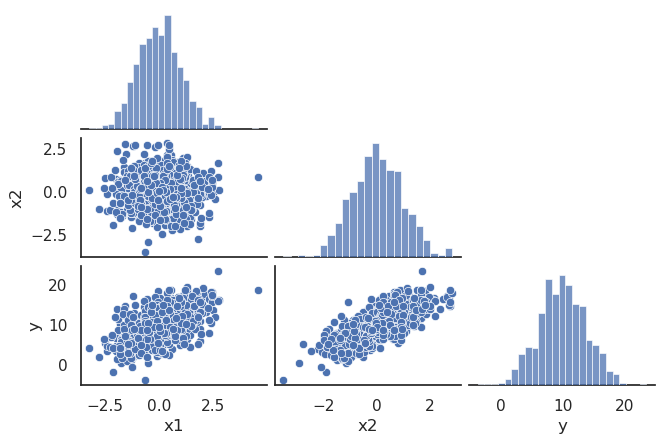

In [138]:
sns.set_style("white")
sns.pairplot(dfTR, corner=True, height=1.5, aspect=1.5);

The plot of the output vs each one of the inputs shows linear trends.  The correlation between inputs seems very low. We confirm that using the correlation matrix.

In [139]:
XTR.corr()

,x1,x2
x1,1.00000,0.00622
x2,0.00622,1.00000


#### Model Formula and Fit


Let us use for this model the formula language that we have described above inside the scikit pipeline framework. Two remarks:
+ In order to use it in a pipeline we only need the right hand side of the formula, the part after ´~´
+ When you just want your formula to say *"using all inputs"* you can use the following construction with [`join`](https://docs.python.org/3/library/stdtypes.html#str.join).

In [140]:
model_Formula = " + ".join(inputs)
model_Formula

'x1 + x2'

And now we can use `FormulaTransformer` with this formula in the first step of the pipeline (it is defined in a taylor-made module `patsy_utils` inspired by [this post](https://juanitorduz.
github.io/formula_transformer/) by Juan Orduz). The `FormulaTransformer` will create (through its fit_transform method) the design matrix of the model for us as illustrated below. Then in the second step we use `LinearRegression` (provided by `sklearn`) to access all the statistical information provided by `statsmodels`.

In [141]:
FormulaTransformer(model_Formula).fit_transform(dfTR)

,Intercept,x1,x2
382,1.0,0.144882,-1.491031
994,1.0,1.443869,-1.596614
982,1.0,1.345697,-0.053474
47,1.0,1.075970,0.288895
521,1.0,-1.313146,-0.029207
...,...,...,...
767,1.0,-0.576899,0.636284
72,1.0,-0.084902,-0.462210
908,1.0,-0.336037,1.811883
235,1.0,-1.191780,0.924044


In [142]:
lm_pipeline = Pipeline([
("formula", FormulaTransformer(model_Formula)),
("regressor", StatsModelsRegressor(OLS, fit_intercept = False))])

Once the pipeline is created, fit proceeds as usual. We create a `model` object, which is in fact a `statsmodels` regressor:

In [143]:
lm_pipeline.fit(dfTR[inputs], dfTR[output])

model = lm_pipeline._final_estimator
model

,model_class,<class 'stats...ar_model.OLS'>
,fit_intercept,False


#### Extracting Information about the Model

The initial information we need is stored in the `results_` property of the model. For example, this is the model's summary, like the one we discussed previously in this session:  

(In this case I recommend using print for a nicer display)


In [144]:
print(model.results_.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     2066.
Date:                Fri, 13 Feb 2026   Prob (F-statistic):          4.83e-316
Time:                        07:15:22   Log-Likelihood:                -1474.4
No. Observations:                 800   AIC:                             2955.
Df Residuals:                     797   BIC:                             2969.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9043      0.054    182.954      0.0

**Always check if the coefficients of the input variables are significant.** In this case they are. And the adjusted $R^2$ shows that this model accounts for 84% of the variability of $Y$ in the training set.

#### Using Residual Plots to Analyze the Model

The following script contains the definition of a convenience function that when provided with a model and its variables plots:

+ The density curve of the residuals. You should check if it looks approximately normal. Besides it you have a QQ-plot of the residuals to help you assess their normality in a different way. They should follow the red line very closely. 
+ A plot of fitted values (the $\hat Y$) against the corresponding residuals. IN this and the following plots, look for unexpected patterns. 
+ The rest of the plots show the residuals against each of the numerical (with scatterplots) or categorical inputs (in this case with parallel boxplots). For the numerical input scatterplots, the distribution of the points should appear random. And in the case of the boxplots, they should look very similar across all levels of the categorical input.


In [218]:
%run -i "./3_1_ResidualPlots.py"

We get those plots in the next cell and comment on them below. 

--------------------------------------------------
Density Curve and QQ-plot of Residuals: ['x1', 'x2']
--------------------------------------------------
[<Axes: > <Axes: >]


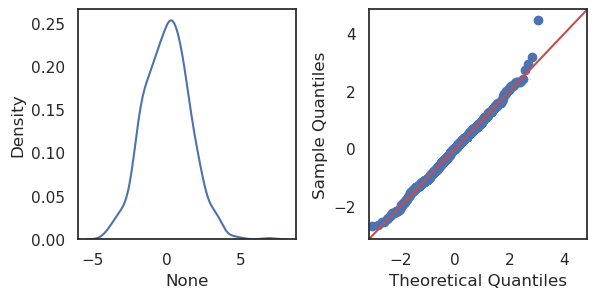

--------------------------------------------------
Fitted Values vs Residuals:
--------------------------------------------------


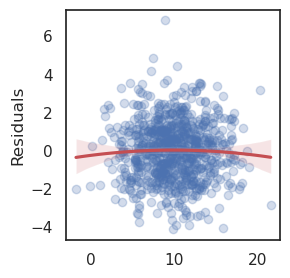

--------------------------------------------------
Numerical inputs: ['x1', 'x2']
--------------------------------------------------
nrows: 1
axes.shape: (1, 3)
k=0, num_inputs[k]=x1
data.shape: (800, 3)
row: 0 col: 0
k=1, num_inputs[k]=x2
data.shape: (800, 3)
row: 0 col: 1


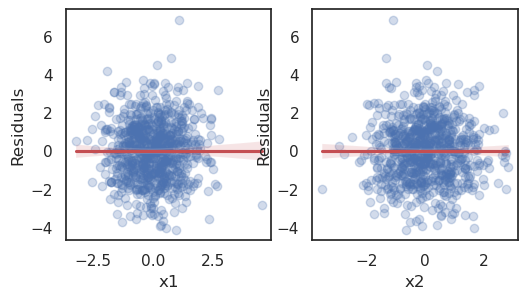

--------------------------------------------------
No categorical inputs exist.
--------------------------------------------------


In [146]:
ResidualPlots(model=model, data=dfTR, num_inputs=num_inputs, cat_inputs=cat_inputs, output=output)

In this our first example everything works as expected. Think of the plots that we obtain here as a model fitting goal: your job is to get the model plots look like these. 

---

::: {.callout-note icon=false}

### Second Example

Let us try to load a second dataset and repeat the previous steps. 

:::

In [147]:
df = pd.read_csv("./3_1_data02.csv")
df.head(4)


,x1,x2,y
0,-0.667721,7.616991,1.969010
1,-3.296181,3.811367,7.340756
2,-6.743649,5.733155,-2.591455
3,-2.077600,-8.420373,-52.285824


In [148]:
output = "y"
num_inputs = ["x1", "x2"]
cat_inputs = []
inputs = num_inputs + cat_inputs
X = df[inputs]
Y = df[output]

Next we create the train/test split.

In [149]:
XTR, XTS, YTR, YTS = train_test_split(
    X, Y,
    test_size = 0.2,  
    random_state = 1) 

dfTR = pd.DataFrame(XTR, columns=inputs)
dfTR[output] = YTR
dfTS = pd.DataFrame(XTS, columns=inputs)
dfTS[output] = YTS

#### EDA 

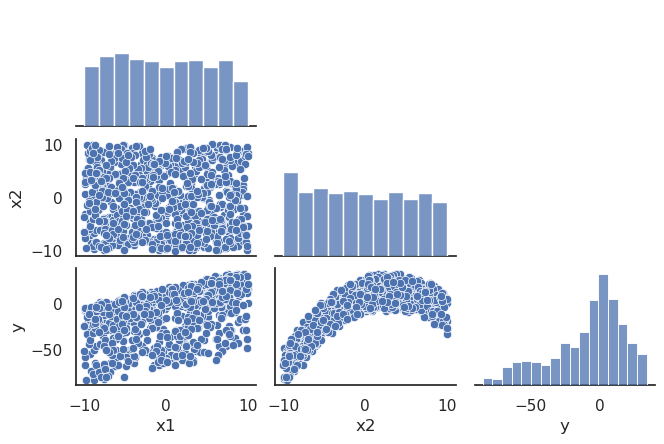

In [150]:
sns.set_style("white")
sns.pairplot(dfTR, corner=True, height=1.5, aspect=1.5);

The obvious non linear pattern in the `Y` vs `X2` plot is our first warning that things are different now. The correlation between inputs however looks fine. 

In [151]:
XTR.corr()

,x1,x2
x1,1.000000,-0.017873
x2,-0.017873,1.000000


#### Model Formula and Fit

Let us first  use the same formula as in the previous model.

In [152]:
model_Formula = " + ".join(inputs)
model_Formula

'x1 + x2'

We create the pipeline and fit the model.

In [153]:
lm_pipeline = Pipeline([
("formula", FormulaTransformer(model_Formula)),
("regressor", StatsModelsRegressor(OLS, fit_intercept = False))])

In [154]:
lm_pipeline.fit(dfTR[inputs], dfTR[output])
model = lm_pipeline._final_estimator

#### Extracting Information about the Model

The model's summary looks ok, all coefficients are significative, but the adjusted $R^2$ is lower than expected. 

In [155]:
print(model.results_.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     788.4
Date:                Fri, 13 Feb 2026   Prob (F-statistic):          1.29e-189
Time:                        07:15:37   Log-Likelihood:                -3306.9
No. Observations:                 800   AIC:                             6620.
Df Residuals:                     797   BIC:                             6634.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.9606      0.538    -12.946      0.0

#### Using Residual Plots to Analyze the Model

The residual plots in this example are the key to discovering that something is wrong with this model. 

--------------------------------------------------
Density Curve and QQ-plot of Residuals: ['x1', 'x2']
--------------------------------------------------
[<Axes: > <Axes: >]


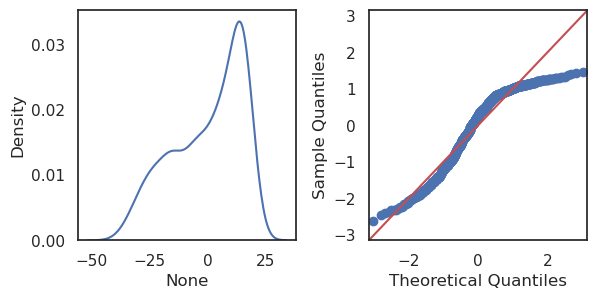

--------------------------------------------------
Fitted Values vs Residuals:
--------------------------------------------------


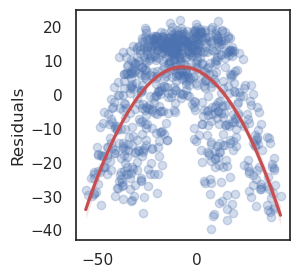

--------------------------------------------------
Numerical inputs: ['x1', 'x2']
--------------------------------------------------
nrows: 1
axes.shape: (1, 3)
k=0, num_inputs[k]=x1
data.shape: (800, 3)
row: 0 col: 0
k=1, num_inputs[k]=x2
data.shape: (800, 3)
row: 0 col: 1


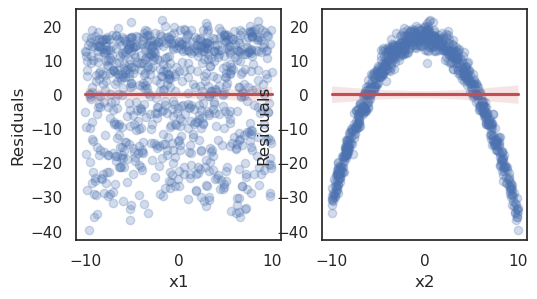

--------------------------------------------------
No categorical inputs exist.
--------------------------------------------------


In [156]:
ResidualPlots(data= dfTR, model=model, num_inputs=num_inputs, cat_inputs=cat_inputs, output=output)

The non normality of the residuals is the first thing that we see. But then the parabolic patterns in some of the residual plots, in particular in the `x2` plot,  tell us that **there is still signal** in the residuals waiting to be captured by our models. The remedy in this case seems clear: try adding polynomial terms in `x2`.


#### Fitting a Second Model with Quadratic Terms

We will not repeat the EDA and proceed directly to the model formula. It only needs updating with the addition of a new term 

In [157]:
model_Formula = model_Formula + "+ I(x2**2)"
model_Formula

'x1 + x2+ I(x2**2)'

We fit this new model:

In [158]:
lm_pipeline = Pipeline([
("formula", FormulaTransformer(model_Formula)),
("regressor", StatsModelsRegressor(OLS, fit_intercept = False))])

lm_pipeline.fit(dfTR[inputs], dfTR[output])
model = lm_pipeline._final_estimator  

The first piece of good news is that the model's summary shows that all coefficients are significative, **including the quadratic term**. And also check the boost in the value of the adjusted $R^2$. This model seems a better fit for the data. 

In [159]:
print(model.results_.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 4.894e+04
Date:                Fri, 13 Feb 2026   Prob (F-statistic):               0.00
Time:                        07:15:43   Log-Likelihood:                -1654.3
No. Observations:                 800   AIC:                             3317.
Df Residuals:                     796   BIC:                             3335.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.2091      0.103     98.726      0.0

The residual plots of this second model now look as expected. The residuals seem normal, and there are no obvious patterns (no signal) remaining in the scatterplots. We consider this a good model from the statistical point of view. 

--------------------------------------------------
Density Curve and QQ-plot of Residuals: ['x1', 'x2']
--------------------------------------------------
[<Axes: > <Axes: >]


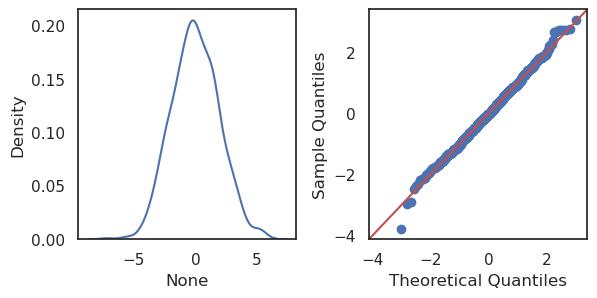

--------------------------------------------------
Fitted Values vs Residuals:
--------------------------------------------------


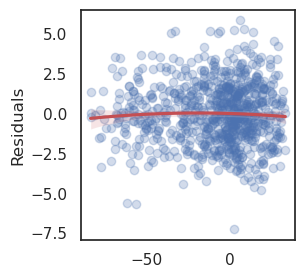

--------------------------------------------------
Numerical inputs: ['x1', 'x2']
--------------------------------------------------
nrows: 1
axes.shape: (1, 3)
k=0, num_inputs[k]=x1
data.shape: (800, 3)
row: 0 col: 0
k=1, num_inputs[k]=x2
data.shape: (800, 3)
row: 0 col: 1


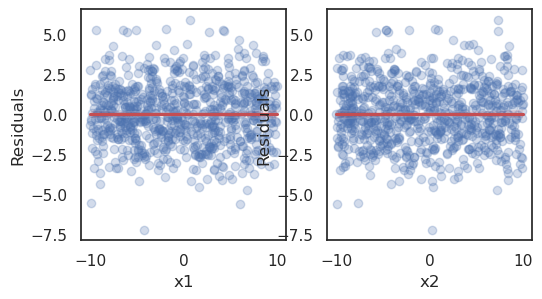

--------------------------------------------------
No categorical inputs exist.
--------------------------------------------------


In [160]:
ResidualPlots(data=dfTR, model=model, num_inputs=num_inputs, cat_inputs=cat_inputs, output=output)

---

# Failures in the  the Linear Model Requirements

::: {.callout-note icon=false}

### Third Example

Our third dataset illustrates a possible problem that you may find yourself in when trying to ft a linear model. 

:::

In [161]:
df = pd.read_csv("./3_1_data03.csv")
df.head(4)

,x1,x2,y
0,2.333070,3.808496,23.584776
1,1.675955,1.905683,18.272128
2,0.814088,2.866577,20.441051
3,1.980600,-4.210186,11.557789


Let us move quickly through the modeling steps until we reach the step where a new situation appears:

In [162]:
output = "y"
num_inputs = ["x1", "x2"]
cat_inputs = []
inputs = num_inputs + cat_inputs
X = df[inputs]
Y = df[output]

In [163]:
XTR, XTS, YTR, YTS = train_test_split(
    X, Y,
    test_size = 0.2,  
    random_state = 1) 

dfTR = pd.DataFrame(XTR, columns=inputs)
dfTR[output] = YTR
dfTS = pd.DataFrame(XTS, columns=inputs)
dfTS[output] = YTS

#### EDA 

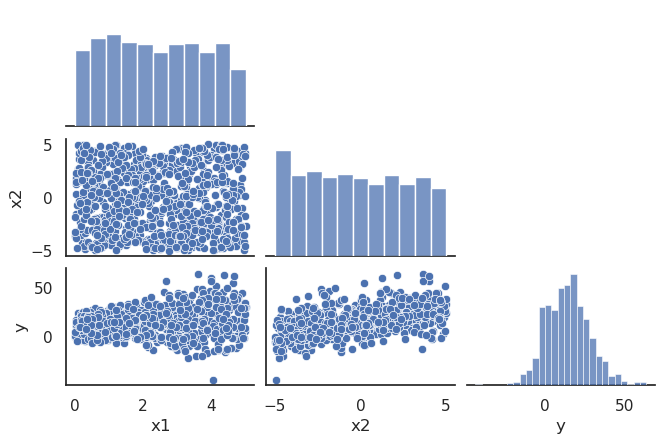

In [164]:
sns.set_style("white")
sns.pairplot(dfTR, corner=True, height=1.5, aspect=1.5);

Do you notice anything unexpected here?  
The correlation between inputs is ok.

In [165]:
XTR.corr()

,x1,x2
x1,1.000000,-0.017873
x2,-0.017873,1.000000


#### Model Formula and Fit

We use the basic *all in* formula as starting point.

In [166]:
model_Formula = " + ".join(inputs)
model_Formula

'x1 + x2'

We create the pipeline and fit the model.

In [167]:
lm_pipeline = Pipeline([
("formula", FormulaTransformer(model_Formula)),
("regressor", StatsModelsRegressor(OLS, fit_intercept = False))])

In [168]:
lm_pipeline.fit(dfTR[inputs], dfTR[output])
model = lm_pipeline._final_estimator

#### Extracting Information about the Model

The model's summary again looks ok, but notice that the adjusted $R^2$ is quite low. 

In [169]:
print(model.results_.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     233.2
Date:                Fri, 13 Feb 2026   Prob (F-statistic):           1.83e-80
Time:                        07:15:54   Log-Likelihood:                -3050.8
No. Observations:                 800   AIC:                             6108.
Df Residuals:                     797   BIC:                             6122.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0687      0.772     13.049      0.0

#### Using Residual Plots to Analyze the Model

The residual plots in this example are the key to discovering that something is wrong with this model. 

--------------------------------------------------
Density Curve and QQ-plot of Residuals: ['x1', 'x2']
--------------------------------------------------
[<Axes: > <Axes: >]


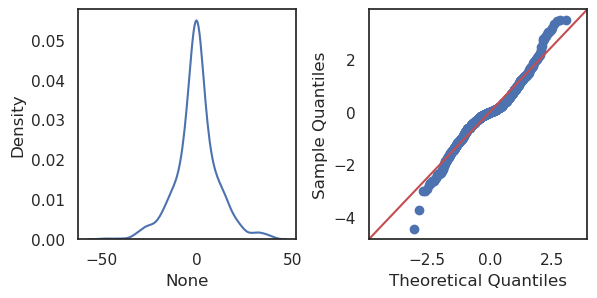

--------------------------------------------------
Fitted Values vs Residuals:
--------------------------------------------------


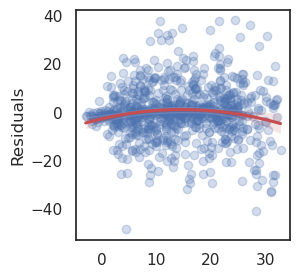

--------------------------------------------------
Numerical inputs: ['x1', 'x2']
--------------------------------------------------
nrows: 1
axes.shape: (1, 3)
k=0, num_inputs[k]=x1
data.shape: (800, 3)
row: 0 col: 0
k=1, num_inputs[k]=x2
data.shape: (800, 3)
row: 0 col: 1


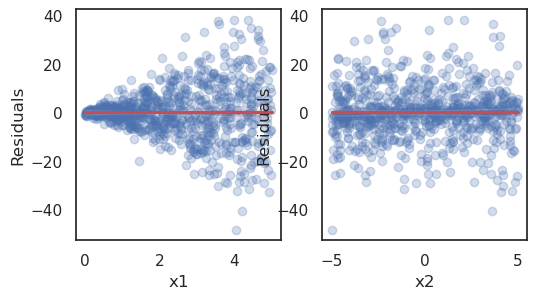

--------------------------------------------------
No categorical inputs exist.
--------------------------------------------------


In [170]:
ResidualPlots(data=dfTR, model=model, num_inputs=num_inputs, cat_inputs=cat_inputs, output=output)

Again there are clear signs of non normality of the residuals. And the most striking feature appears in the residuals vs `x1` plot. There is a clear wedge shape that says that the variance of the residuals depends on the values of `x1`. This goes directly against the assumption of equal conditional variance of the errors. 

**Be careful:** this model can still be a good predictor of `Y`. But we can not use it for inference and in particular we can not trust the p-values in the model's summary or compute confidence intervals, etc. Always keep in mind that the Machine Learning goals and the statistical goals are often not exactly the same. 


---

::: {.callout-note icon=false}

### Fourth Example

Our third dataset illustrates a possible problem that you may find yourself in when trying to ft a linear model. 

:::

In [171]:
df = pd.read_csv("./3_1_data04.csv")
df.head(4)

,x1,x2,y
0,2.333070,3.808496,32.086970
1,1.675955,1.905683,20.262496
2,0.814088,2.866577,41.888154
3,1.980600,-4.210186,6.126667


Again let us go quickly to the interesting part:

In [172]:
output = "y"
num_inputs = ["x1", "x2"]
cat_inputs = []
inputs = num_inputs + cat_inputs
X = df[inputs]
Y = df[output]

In [173]:
XTR, XTS, YTR, YTS = train_test_split(
    X, Y,
    test_size = 0.2,  
    random_state = 1) 

dfTR = pd.DataFrame(XTR, columns=inputs)
dfTR[output] = YTR
dfTS = pd.DataFrame(XTS, columns=inputs)
dfTS[output] = YTS

#### EDA 

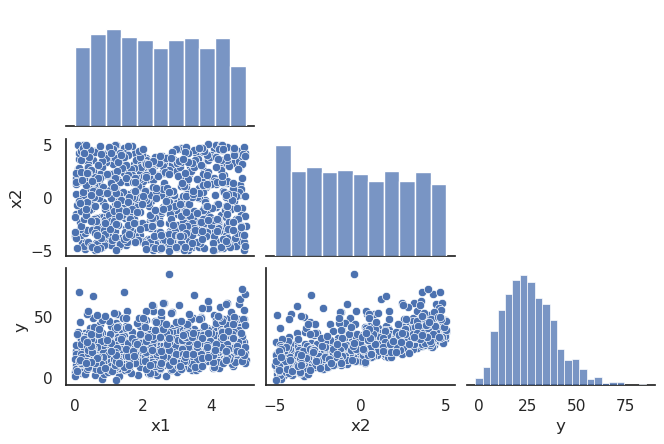

In [174]:
sns.set_style("white")
sns.pairplot(dfTR, corner=True, height=1.5, aspect=1.5);

Probably nothing pops out here. The correlation between inputs is also ok.

In [175]:
XTR.corr()

,x1,x2
x1,1.000000,-0.017873
x2,-0.017873,1.000000


#### Model Formula and Fit

We use the basic *all in* formula as starting point.

In [176]:
model_Formula = " + ".join(inputs)
model_Formula

'x1 + x2'

We create the pipeline and fit the model.

In [177]:
lm_pipeline = Pipeline([
("formula", FormulaTransformer(model_Formula)),
("regressor", StatsModelsRegressor(OLS, fit_intercept = False))])

In [178]:
lm_pipeline.fit(dfTR[inputs], dfTR[output])
model = lm_pipeline._final_estimator

#### Extracting Information about the Model

The p-values are ok, but the low adjusted $R^2$ is intriguing. 

In [179]:
print(model.results_.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     310.5
Date:                Fri, 13 Feb 2026   Prob (F-statistic):          1.96e-100
Time:                        07:16:08   Log-Likelihood:                -2977.1
No. Observations:                 800   AIC:                             5960.
Df Residuals:                     797   BIC:                             5974.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.9059      0.704     31.130      0.0

#### Using Residual Plots to Analyze the Model

The residual plots in this example are the key to discovering that something is wrong with this model. 

--------------------------------------------------
Density Curve and QQ-plot of Residuals: ['x1', 'x2']
--------------------------------------------------
[<Axes: > <Axes: >]


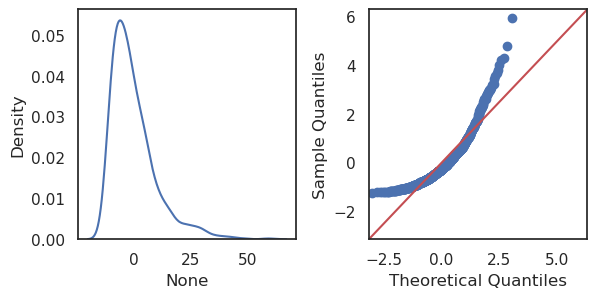

--------------------------------------------------
Fitted Values vs Residuals:
--------------------------------------------------


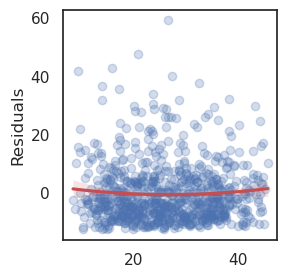

--------------------------------------------------
Numerical inputs: ['x1', 'x2']
--------------------------------------------------
nrows: 1
axes.shape: (1, 3)
k=0, num_inputs[k]=x1
data.shape: (800, 3)
row: 0 col: 0
k=1, num_inputs[k]=x2
data.shape: (800, 3)
row: 0 col: 1


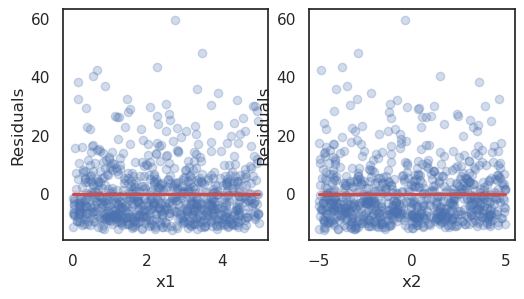

--------------------------------------------------
No categorical inputs exist.
--------------------------------------------------


In [180]:
ResidualPlots(data=dfTR, model=model, num_inputs=num_inputs, cat_inputs=cat_inputs, output=output)

In this case the non normality of the residuals is the culprit of the problems we see in the plots. The distribution of the residuals seems skewed (non symmetrical) in most of them. 

The caveats we made before about models like this being statistically flawed but possible good predictors of `Y` still hold here. 


---

# The Problem of Collinearity

::: {.callout-note icon=false}

### Collinearity and When is it a Problem? Variance Inflation Factors.

**Collinearity or Multicollinearity** refer to the situation when the input variables of a model are or are very close to being linearly dependent. That means that the rank of the design matrix $\mathbf X$ is not maximal. In some cases this causes numerical problems in the fit of the model.  However, many modern implementations can deal with this and still fit models and return accurate predictions for the training set even in this rank deficient setting. We will see an example below. And if the test set has (as expected) a similar distribution to the training set, then even perfect collinearity is often not a problem for prediction. We will see this in the example below. 

Why then should we worry about collinearity? Because one of the advantages of linear models is their interpretability, and collinearity makes all the coefficient estimates and inferential results unreliable. Different samples or different software libraries can result in arbitrarily different coefficients for the model. 

When two variables are highly correlated we can expect to detect this in EDA using the correlation matrix. But if the the correlation structure is more complicated (multicollinearity) then this may not be enough. In order to detect multicollinearity in such cases we usually employ the **variable inflation factors (VIF)**. This is essentially measuring the result of regressing each input variable over the rest of the original inputs. The VIFs (one per input variable) are a numerical measure of the fit of such models. As a rule of thumb, a VIF value greater than 5 is usually considered an indicator of the presence of multicollinearity in the data set.


:::

---

::: {.callout-note icon=false}

### Fifth Example

The following example illustrates the above discussion in a simple scenario in which there is a strong multicollinearity between the inputs. First we explore the data and fit the model quickly as we have done before.  

:::

In [181]:
df = pd.read_csv("./3_1_data05.csv")
df.head(4)

,x1,x2,x3,y
0,2.333070,3.808496,8.206014,22.750828
1,1.675955,1.905683,5.138731,17.417961
2,0.814088,2.866577,4.560207,16.625784
3,1.980600,-4.210186,1.041929,4.490612


In [182]:
output = "y"
num_inputs = ["x1", "x2", "x3"]
cat_inputs = []
inputs = num_inputs + cat_inputs
X = df[inputs]
Y = df[output]

In [183]:
XTR, XTS, YTR, YTS = train_test_split(
    X, Y,
    test_size = 0.2,  
    random_state = 1) 

dfTR = pd.DataFrame(XTR, columns=inputs)
dfTR[output] = YTR
dfTS = pd.DataFrame(XTS, columns=inputs)
dfTS[output] = YTS

#### EDA 

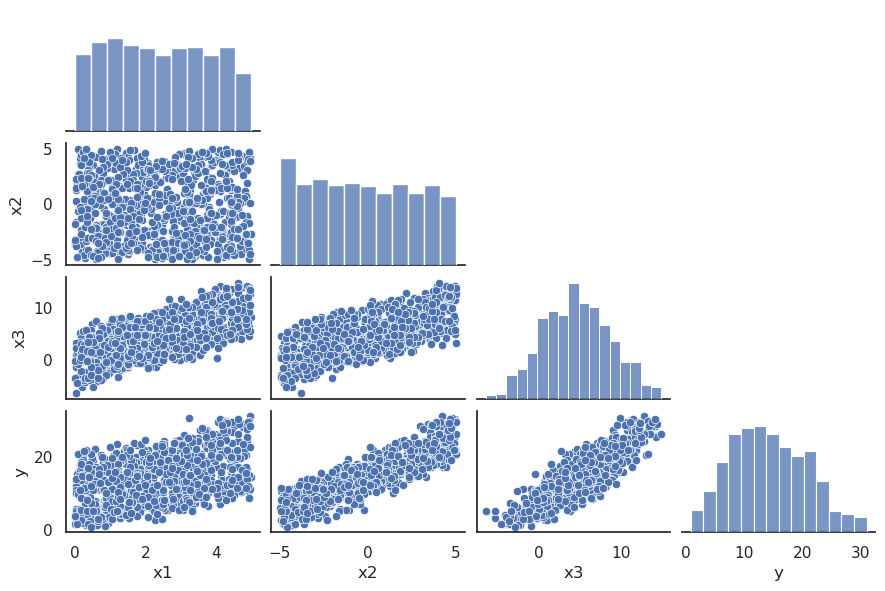

In [184]:
sns.set_style("white")
sns.pairplot(dfTR, corner=True, height=1.5, aspect=1.5);

In this example **EDA already indicates the problem, but that will not always be the case.** 

In [185]:
XTR.corr()

,x1,x2,x3
x1,1.000000,-0.017873,0.672476
x2,-0.017873,1.000000,0.689660
x3,0.672476,0.689660,1.000000


#### Model Formula and Fit

As usual

In [186]:
model_Formula = " + ".join(inputs)
model_Formula

'x1 + x2 + x3'

Pipeline and fit

In [187]:
lm_pipeline = Pipeline([
("formula", FormulaTransformer(model_Formula)),
("regressor", StatsModelsRegressor(OLS, fit_intercept = False))])

In [188]:
lm_pipeline.fit(XTR, YTR)
model = lm_pipeline._final_estimator

#### Extracting Information about the Model

Note that the p-values and $R^2$ all look ok. But looking back at the EDA pairplot, how come that the `x3` coefficient is negative?

In [189]:
print(model.results_.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 1.076e+04
Date:                Fri, 13 Feb 2026   Prob (F-statistic):               0.00
Time:                        07:16:39   Log-Likelihood:                -1147.9
No. Observations:                 800   AIC:                             2304.
Df Residuals:                     796   BIC:                             2323.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0200      0.072    140.006      0.0

#### Using Residual Plots to Analyze the Model

The residual plots also look perfectly well in this model. 

--------------------------------------------------
Density Curve and QQ-plot of Residuals: ['x1', 'x2', 'x3']
--------------------------------------------------
[<Axes: > <Axes: >]


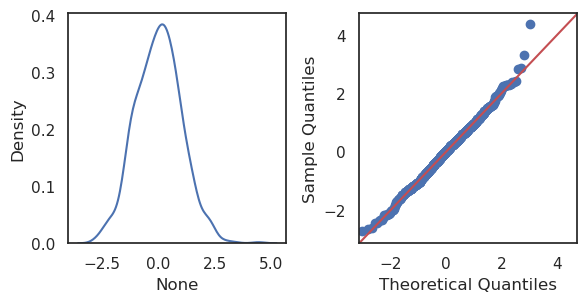

--------------------------------------------------
Fitted Values vs Residuals:
--------------------------------------------------


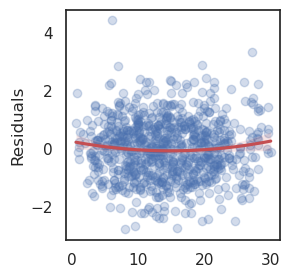

--------------------------------------------------
Numerical inputs: ['x1', 'x2', 'x3']
--------------------------------------------------
nrows: 1
axes.shape: (1, 3)
k=0, num_inputs[k]=x1
data.shape: (800, 3)
row: 0 col: 0
k=1, num_inputs[k]=x2
data.shape: (800, 3)
row: 0 col: 1
k=2, num_inputs[k]=x3
data.shape: (800, 3)
row: 0 col: 2


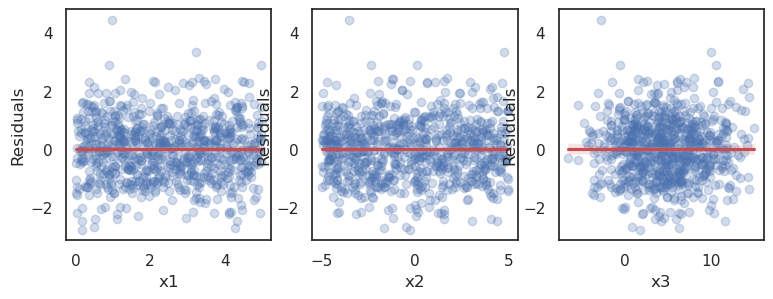

--------------------------------------------------
No categorical inputs exist.
--------------------------------------------------


In [190]:
ResidualPlots(data = XTR, model=model, num_inputs=num_inputs, cat_inputs=cat_inputs, output=output)

#### Computing the VIFs and Checking Predictive Performance

Now let us examine the VIFS for this model. Remember that a VIF > 5 is considered a signal of multicollinearity.

In [191]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
vif_df = pd.DataFrame() 
vif_df["Variable"] = df[inputs].columns 
  
# calculating VIF for each feature b
vif_df["VIF"] = [variance_inflation_factor(dfTR[inputs].values, i) 
                          for i in range(len(dfTR[inputs].columns))] 
vif_df


,Variable,VIF
0,x1,34.832504
1,x2,9.974203
2,x3,41.052912


As you can see, these are clear indicators of multicollinearity. But the predictive performance is not hurt because of this, as you can see in the following trains, validation and test score comparisons.

In [192]:
## Create dataset to store model predictions
dfTR_eval = XTR.copy()
dfTR_eval[output] = YTR
dfTS_eval = XTS.copy()
dfTS_eval[output] = YTS

In [193]:
dfTR_eval['model_pred'] = lm_pipeline.predict(XTR)
dfTS_eval['model_pred'] = lm_pipeline.predict(XTS)


Now let us compute the RMSE score in training, validation and test:

In [194]:
np.sqrt(mean_squared_error(YTR, dfTR_eval["model_pred"]))

np.float64(1.016091274761776)

In [195]:
- cross_val_score(lm_pipeline, XTR, YTR, cv=10, scoring="neg_root_mean_squared_error")

array([1.08376295, 1.01528054, 1.01276996, 1.04037752, 0.98126073,
       1.0291144 , 0.98930486, 1.04502459, 1.07973088, 0.93764737])

In [196]:
np.sqrt(mean_squared_error(YTS, dfTS_eval["model_pred"]))

np.float64(0.9559781249766734)

As we see, the scores in train, validation and test are coherent. 

#### Fitting a Second Model

In order to fight multicollinearity we will fit a second model removing the variable with the highest VIF value, in this case `x1` (if two variables have very similar VIFs you may keep e.g. the most easily interpretable one).  

In [197]:
inputs = ["x1", "x2"]
inputs

['x1', 'x2']

In [198]:
model_Formula = " + ".join(inputs)
model_Formula

'x1 + x2'

We create the pipeline and fit the model.

In [199]:
lm_pipeline = Pipeline([
("formula", FormulaTransformer(model_Formula)),
("regressor", StatsModelsRegressor(OLS, fit_intercept = False))])

In [200]:
lm_pipeline.fit(dfTR[inputs], dfTR[output])
model = lm_pipeline._final_estimator

#### Extracting Information about the Model

Everything looks good here:

In [201]:
print(model.results_.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     7969.
Date:                Fri, 13 Feb 2026   Prob (F-statistic):               0.00
Time:                        07:16:55   Log-Likelihood:                -1421.0
No. Observations:                 800   AIC:                             2848.
Df Residuals:                     797   BIC:                             2862.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9864      0.101     99.260      0.0

**Note the changes in the model coefficients** for the remaining variables. Even the sign has changed! Let us see the new VIFs:

In [202]:
vif_df = pd.DataFrame() 
vif_df["Variable"] = dfTR[inputs].columns 
  
# calculating VIF for each feature 
vif_df["VIF"] = [variance_inflation_factor(dfTR[inputs].values, i) 
                          for i in range(len(dfTR[inputs].columns))] 
vif_df

,Variable,VIF
0,x1,1.006232
1,x2,1.006232


As you can see the VIF values are much more moderate in this second model. This makes the coefficient estimates more reliable (the real coefficients in this example are `10 + 2 x1 + 2 x2`)

::: {.callout-tip  icon=false}

### Exercise 008

Check the prediction scores for this second model. You should not expect a big difference with the previous one.

:::

---

# Models with Categorical Inputs

::: {.callout-note icon=false}

### A Simple Example

The following example simply illustrates how we incorporate categorical inputs in our models in the most basic settings.

:::

In [203]:
df = pd.read_csv("./3_1_data06.csv")
df.head(4)

,x1,x2,y
0,2.333070,A,23.870012
1,1.675955,B,17.088453
2,0.814088,A,11.796125
3,1.980600,B,22.636752


As we can see, `x2` is a factor encoded with non numeric labels. This is the easiest case as our code will be able to recognize this automatically and build the right design matrix. We store the names for the inputs and make the train/test split as in previous models:

In [204]:
output = "y"
num_inputs = ["x1" ]
cat_inputs = ["x2"]
inputs = num_inputs + cat_inputs
X = df[inputs]
Y = df[output]

XTR, XTS, YTR, YTS = train_test_split(
    X, Y,
    test_size = 0.2,  
    random_state = 1) 

dfTR = pd.DataFrame(XTR, columns=inputs)
dfTR[output] = YTR
dfTS = pd.DataFrame(XTS, columns=inputs)
dfTS[output] = YTS

#### EDA 

With a categorical input it is usually a good idea to incorporate its levels into the pairplots. Note, for example. the vertical arrangement of colors in the `Y` vs `x1` scatterplot.

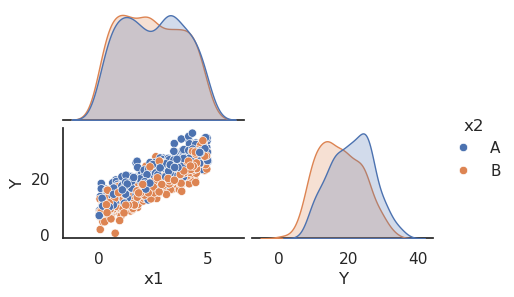

In [205]:
sns.set_style("white")
plt_df = XTR.copy()
plt_df["Y"] = YTR
sns.pairplot(plt_df, corner=True, height=1.5, aspect=1.5, hue="x2");

#### Model Formula and Fit

In this example if we use a basic formula incorporating all inputs

In [206]:
model_Formula = " + ".join(inputs)
model_Formula

'x1 + x2'

then the design matrix will automatically include a column with the right encoding of the categorical input (read the warning!). Let us see how:

In [207]:
dmY, dmX = ps.dmatrices("y ~ " + model_Formula, df)
dmX[:4, :]

array([[1.        , 0.        , 2.33306972],
       [1.        , 1.        , 1.67595477],
       [1.        , 0.        , 0.81408781],
       [1.        , 1.        , 1.98060009]])

::: {.callout-warning icon=false}

### Important: this is not One Hot Encoding

One hot encodings as we have seen them are always multicollinear because they add up to one. The encoding used here is uses only a column, the second one, removing that redundancy in ohe to avoid multicollinearity. 

:::

The following steps are familiar. We create the pipeline and fit the model.

In [208]:
lm_pipeline = Pipeline([
("formula", FormulaTransformer(model_Formula)),
("regressor", StatsModelsRegressor(OLS, fit_intercept = False))])

In [209]:
lm_pipeline.fit(XTR, YTR)
model = lm_pipeline._final_estimator

#### Check the Model Results

The rest of the assessment of the model follows. 

In [210]:
print(model.results_.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     1449.
Date:                Fri, 13 Feb 2026   Prob (F-statistic):          3.60e-266
Time:                        07:17:09   Log-Likelihood:                -2024.7
No. Observations:                 800   AIC:                             4055.
Df Residuals:                     797   BIC:                             4069.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.0499      0.243     45.408      0.0

Note that the coefficient of the categorical input indicates the level of the factor used as reference. Here we are using a model with:

$$f(x_1, x_2) = \beta_0 + \beta_1 x_1 + \beta_2 x_2^{enc}$$

Here $x_2^{enc}$ corresponds to the encoding of $x_2$ in the design matrix, which is 1 when $x_0 = B$ and 0 when $X_2 = A$. In particular that means that the above equation can be interpreted as a straight line in $x_1$ where the intercept depends on the level of $x_2$: it equals $\beta_0$ for $x_2 = A$ (reference level) and $\beta_0 + \beta_2$ for $x_2 = B$. After defining the evaluation datasets we can plot a regression line for each level of `x2` to illustrate this. 

In [211]:
dfTR_eval = XTR.copy()
dfTR_eval[output] = YTR
dfTS_eval = XTS.copy()
dfTS_eval[output] = YTS

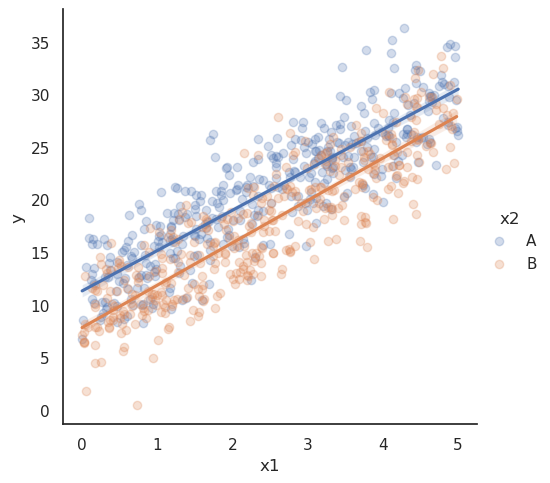

In [212]:
sns.lmplot(data=dfTR, x="x1", y="y", hue="x2", scatter_kws={'alpha':0.25});

#### Using Residual Plots to Analyze the Model

The residual plots for this model now include parallel boxplots of the residuals across different levels of the categorical input(s). There should be no significant difference in the boxplots for each level, as in this example. 

--------------------------------------------------
Density Curve and QQ-plot of Residuals: ['x1']
--------------------------------------------------
[<Axes: > <Axes: >]


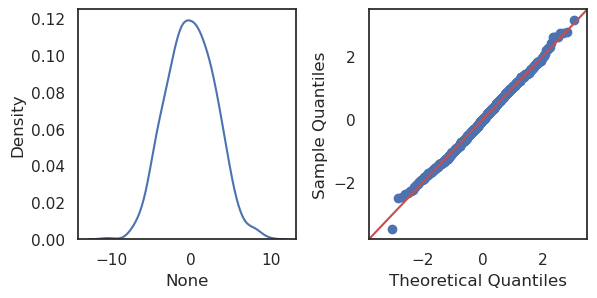

--------------------------------------------------
Fitted Values vs Residuals:
--------------------------------------------------


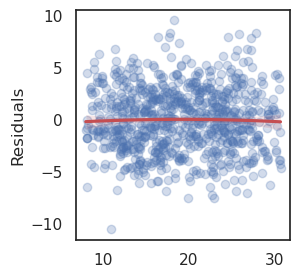

--------------------------------------------------
Numerical inputs: ['x1']
--------------------------------------------------
nrows: 1
axes.shape: (1, 3)
k=0, num_inputs[k]=x1
data.shape: (800, 3)
row: 0 col: 0


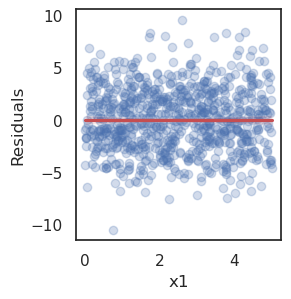

--------------------------------------------------
Categorical inputs: ['x2']
--------------------------------------------------


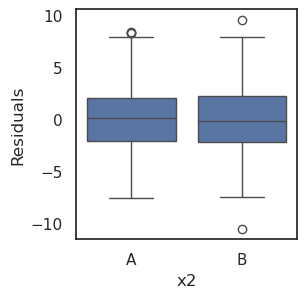

In [219]:
ResidualPlots(data = dfTR, model=model, num_inputs=num_inputs, cat_inputs=cat_inputs, output=output)

---

::: {.callout-note icon=false}

### An Example with a MultiLevel Factor  

When an input factor has more than two levels and they are represented with numbers you have to be careful and define the formula providing extra information to make sure that the factor is not confused with a numerical input. The following example briefly illustrates that point with a factor that has 4 levels.

:::

In [220]:
df = pd.read_csv("./3_1_data07.csv")
df.head(8)


,x1,x2,y
0,2.333070,1,22.866299
1,1.675955,2,22.709764
2,0.814088,3,16.807665
3,1.980600,4,30.362348
4,0.151959,1,13.194814
5,0.604424,2,15.083150
6,2.130828,3,27.724743
7,3.089289,4,36.682985


Here, if we simply run the next two cells as in the previous example:

In [221]:
model_Formula = " + ".join(inputs)
model_Formula

'x1 + x2'

then the design matrix will include a single column for the categorical input, and it will not be really considered as such.

In [222]:
dmY, dmX = ps.dmatrices("y ~ " + model_Formula, df)
dmX[:4, :]

array([[1.        , 2.33306972, 1.        ],
       [1.        , 1.67595477, 2.        ],
       [1.        , 0.81408781, 3.        ],
       [1.        , 1.98060009, 4.        ]])

In order to get the right encoding of categorical inputs we need to be more specific when writing the model formula:

In [223]:
model_Formula = "x1 + C(x2)"
model_Formula

'x1 + C(x2)'

Now the design matrix correctly encodes the categorical input in three columns, leaving the first level of `x2` as reference level. Again we insist this is not the same as one hot encoding (which would include all four columns). 

In [224]:
dmY, dmX = ps.dmatrices("y ~ " + model_Formula, df)
dmX[:8, :]

array([[1.        , 0.        , 0.        , 0.        , 2.33306972],
       [1.        , 1.        , 0.        , 0.        , 1.67595477],
       [1.        , 0.        , 1.        , 0.        , 0.81408781],
       [1.        , 0.        , 0.        , 1.        , 1.98060009],
       [1.        , 0.        , 0.        , 0.        , 0.15195865],
       [1.        , 1.        , 0.        , 0.        , 0.60442435],
       [1.        , 0.        , 1.        , 0.        , 2.13082829],
       [1.        , 0.        , 0.        , 1.        , 3.0892894 ]])

::: {.callout-tip  icon=false}

### Exercise 009

Finish the EDA and model fit for this dataset and think about the interpretation of the coefficients of the model. 

:::

---

# Interactions

::: {.callout-note icon=false}

### A More Complex Relation between Input Variables

In our first example above for categorical inputs (dataset in `data06.csv`) we saw how the levels of the factor could be thought of as determining the intercept of the regression line for a numerical input. In the next example we will see that sometimes the slope of the line is also under the influence of the factor.  

:::

In [225]:
df = pd.read_csv("./3_1_data08.csv")
df.head(4)

,x1,x2,y
0,1.058582,B,0.311131
1,1.683179,B,-3.298882
2,2.241449,A,-0.489514
3,3.509912,B,-3.546480


Let us define the split and the associated names: 

In [226]:
output = "y"
num_inputs = ["x1" ]
cat_inputs = ["x2"]
inputs = num_inputs + cat_inputs
X = df[inputs]
Y = df[output]

XTR, XTS, YTR, YTS = train_test_split(
    X, Y,
    test_size = 0.2,  
    random_state = 1, 
    shuffle=True) 

dfTR = pd.DataFrame(XTR, columns=inputs)
dfTR[output] = YTR
dfTS = pd.DataFrame(XTS, columns=inputs)
dfTS[output] = YTS

An exploratory plot like the one we did before reveals the difference between this and the preceding situation:

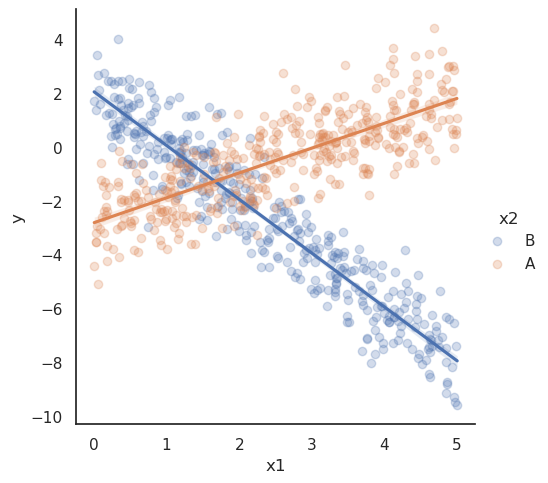

In [227]:
sns.lmplot(data=dfTR, x="x1", y="y", hue="x2", scatter_kws={'alpha':0.25});

::: {.callout-note icon=false}

### Interactions

The plot above illustrates the basic case of what is called an interaction between input variables. In this case the slope of the regression line for `y` over `x1` also depends on the level of `x2`. One way to express this using the equation of the linear model is to modify the previous version writing:

$$f(x_1, x_2) = \beta_0 + (\beta_1  + \beta_3 x_2^{enc}) x_1  + \beta_2$$

for certain coefficient $\beta_3$. This can be rearranged as:

$$f(x_1, x_2) = \beta_0 + \beta_1  x_1 + \beta_2 x_2^{enc} + \beta_3 x_1\, x_2^{enc}$$

where now the model incorporates a new so called **interaction term** which is the product of the two variables. Note that when `x_2= A` or equivalently `x_2^{enc} =  0` then the model turns into a regression line for `x1` with slope $\beta_1$ and intercept $\beta_0$: 

$$f(x_1, x_2) = \beta_0 + \beta_1  x_1$$

whereas if `x_2 = B` or equivalently `x_2^{enc} =  1` it turns into a different line, with slope $\beta_1  + \beta_3$ and intercept $\beta_0 + \beta_2$:

$$f(x_1, x_2) = (\beta_0 + \beta_2) + (\beta_1  + \beta_3) x_1$$

:::

The pairplot using `x2` for color sends a similar warning.

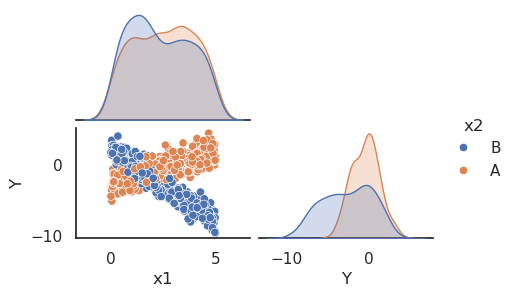

In [228]:
sns.set_style("white")
plt_df = XTR.copy()
plt_df["Y"] = YTR
sns.pairplot(plt_df, corner=True, height=1.5, aspect=1.5, hue="x2");

::: {.callout-tip  icon=false}

### Exercise 010

**Important:** quickly fit a model with the formula `y ~ x1 + x2` and look at the residual plots of the model. If you missed the interaction in the EDA this will give you a second chance to spot the need for a different model. 

:::

::: {.callout-note icon=false}

### Model Formulas for Interactions

In Python we can extend the formula language to describe a model such as

$$f(x_1, x_2) = \beta_0 + \beta_1  x_1 + \beta_2 x_2^{enc} + \beta_3 x_1\, x_2^{enc}$$

by writing:

`y ~ x1 + x2 + x1:x2`

or simply 

`y ~ (x1 * x2)`

This last version means *the variables and their (first order) interactions.* The code below displays the first rows of the design matrix for this model. Note that the last column is simply the product of the preceding two. 

:::

In [229]:
model_Formula = " * ".join(inputs)
model_Formula

dmY, dmX = ps.dmatrices("y ~ " + model_Formula, df)
dmX[:8, :]

array([[1.        , 1.        , 1.05858222, 1.05858222],
       [1.        , 1.        , 1.68317947, 1.68317947],
       [1.        , 0.        , 2.24144939, 0.        ],
       [1.        , 1.        , 3.50991229, 3.50991229],
       [1.        , 0.        , 4.93437   , 0.        ],
       [1.        , 0.        , 0.60442435, 0.        ],
       [1.        , 1.        , 4.32156963, 4.32156963],
       [1.        , 0.        , 2.96544222, 0.        ]])

::: {.callout-tip  icon=false}

### Exercise 011

Now fit a second model with the formula with interactions and compare its results with the previous no-interaction  model. 

:::

---

::: {.callout-tip  icon=false}

### Exercise 012

Interactions are not limited to factors. If `x1` and `x2` are both numeric inputs, their interaction can be represented by the same type of product formula

$$\beta_0 + \beta_1  x_1 + \beta_2 x_2 + \beta_3 x_1\, x_2$$

Use the dataset  to explore a situation like that. 

:::

---

::: {.callout-note  icon=false}

## In the Next Session

We will talk about feature selection and regularization in linear models.

:::

---

::: {.callout-note  icon=false}

### Recommended reading:

See [References](#References) section at the end for details.

+ Chapter 3 of [@ISLP2023]
+ Chapter 2 (pp. 47 and following) of [@IMLPY]
+ [Chapter 5 of [@PDSH]](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html)
+ Chapters 2 and 3 of [@ESLI2009] 
+ Chapter 11 of [@pml1].

:::

# References